# Neural Signal Processing Data Demonstration

Wesley Borden

## Introduction

The first objective of my MS project is to increase understanding of "(a) basic neural signal processing, (b) current approaches for electrophysiology
data processing and (c) general principles for existing related work in micro-connectomics". After literature review, my goal to demonstrate this understanding was to build "A revised/forked python package based on the International Brain Lab electrophysiology data processing python package(s), with a jupyter notebook tutorial demonstrating the neural signal processing tools". While I studied the data processing pipelines implemented by these tools (e.g., kilosort, iblsorter) I identified that these pipelines included more steps than I could include in the scope of this deliverable. Therefore, here I demonstrate how pre-processed data from the International Brain Lab (IBL, a consortium leading basic science research in this space) can be accessed programmatically and understood conceptually, in preparation for the further analyses on which my project will focus.

This demonstration is based on other demonstrations and documentation provided by the IBL [[1](https://colab.research.google.com/drive/1Ua-NlpYYZCIOF56xbsT9YR71Enkotd-b#scrollTo=7XzVVlhsVHMK), [2](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7#scrollTo=), [3](https://colab.research.google.com/drive/1th3MRZGHMSaeAvGmKGJQ84rBk8eEI4Fu), [4](https://colab.research.google.com/drive/1zr6lP_zzRgPZuHs3nB5oGnFtPKrduQ3L), [5](https://int-brain-lab.github.io/ONE/), [6](https://int-brain-lab.github.io/iblenv/), [7](https://github.com/int-brain-lab/ibl-sorter)]. This notebook and its code were also produced with the aid of internet and LLM tools to aid learning and speed up accessory work such as visualizations.

## Setup

### Imports

See this repository's `pyproject.toml`, `setup-deps.sh`, `Dockerfile`, and `.devcontainer/devcontainer.json` for dependency installation.

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from brainbox.io.one import SpikeSortingLoader
from brainbox.io.spikeglx import Streamer  # type: ignore
from ibldsp.voltage import destripe, destripe_lfp  # type: ignore
from iblutil.util import Bunch
from one.alf.io import AlfBunch
from one.api import OneAlyx, ONE  # Docs: https://int-brain-lab.github.io/ONE/

### Helper Class, etc.

IBL provides an api for access to all their data:

In [2]:
one_alyx: OneAlyx = ONE(
    cache_dir="/Users/wesley/GitHub/BYU/ms-proj/tmp/one-cache",  # any directory where temporary files can be synced
    base_url="https://openalyx.internationalbrainlab.org",  # base url for the API
    password="international",  # public-access password
    silent=True,  # don't print progress, etc.
)  # most 'type: ignore' are because IBL's libraries are less strict on types # type: ignore

IBL has collected data from >450 experiments with >100 mice. Each in each experiment (session), mice are given behavioral tests while 1-2 Neuropixels probes record extracellular potentials associated with up to hundreds of neurons. Data are organized by session and probe insertion, with a 1-to-many relationship between session and insertion. Accessible data is associated with the session (e.g., behavior) or an insertion (e.g., neural activity). This is detailed in the most recent data release [8](https://figshare.com/articles/preprint/Data_release_-_Brainwide_map_-_Q4_2022/21400815?file=49286065).

In [3]:
data_tag = "2024_Q2_IBL_et_al_BWM_iblsort"  # tag for most recent data release ()
all_sessions: list = one_alyx.search(  # list of sessions
    tag=data_tag, query_type="remote"
)  # type: ignore
n_sessions = len(all_sessions)
print(f"Session count: {n_sessions}")
print(f"Session example: {all_sessions[0]}")

all_insertions: list = one_alyx.search_insertions(  # list of insertions
    tag=data_tag, query_type="remote"
)  # type: ignore
n_insertions = len(all_insertions)
print(f"Insertion count: {n_insertions}")
print(f"Insertion example: {all_insertions[0]}")

Session count: 459
Session example: ebce500b-c530-47de-8cb1-963c552703ea
Insertion count: 699
Insertion example: 8c732bf2-639d-496c-bf82-464bc9c2d54b


## Choose an insertion to explore

In [4]:
# We could randomly select a probe/insertion for data exploration
i = random.randint(0, (n_insertions - 1))
pid = str(all_insertions[i])
# However, we'll use the same one for consistency between this demo and other IBL demos
pid_i = 534

# get the experimental session id and probe/insertion name
pid: str = str(all_insertions[pid_i])
pid_details: tuple[str, str] = one_alyx.pid2eid(pid)
eid, p_name = pid_details

print(f"Probe ID: {pid}")
print(f"Probe Name: {p_name}")
print(f"Experiment ID: {eid}")

Probe ID: 695476f6-4c14-4a2f-b658-948514629079
Probe Name: probe00
Experiment ID: 4720c98a-a305-4fba-affb-bbfa00a724a4


## Stream and visualize recorded data

### Streamer

Electrophysiology probes (Neuropixels) complete initial signal processing on-device, providing voltages associated with action potentials (AP) and local field potentials (LFP/LF) at each recording site (channel) over time at a specified frequency [[9](https://doi.org/10.1038/nature24636), [10](https://doi.org/10.1126/science.abf4588)]. This gives 10's of gigabytes per experiment in raw electrophysiology data, which can be streamed as follows.

In [5]:
ap_streamer = Streamer(pid=pid, one=one_alyx, remove_cached=False, typ="ap")
lf_streamer = Streamer(pid=pid, one=one_alyx, remove_cached=False, typ="lf")

2025-07-04 11:14:16 WARNING  spikeglx.py:694  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


### Timeframe

In [6]:
start_time = 150  # seconds since beginning the electrophysiology recording
end_time = 152  # seconds since beginning the electrophysiology recording

ap_freq: int = int(ap_streamer.fs)  # ap sampling frequency # type: ignore
lf_freq: int = int(lf_streamer.fs)  # lf sampling frequency # type: ignore

start_ap: int = int(start_time) * int(ap_freq)
end_ap: int = int(end_time) * int(ap_freq)
start_lf: int = int(start_time) * int(lf_freq)
end_lf: int = int(end_time) * int(lf_freq)

### Raw Data

In [7]:
ap_timeframe_data: np.ndarray = ap_streamer[start_ap:end_ap]  # type: ignore
lf_timeframe_data: np.ndarray = lf_streamer[start_lf:end_lf]  # type: ignore

print(
    f"We have numpy matrices for the AP voltage data with shape {ap_timeframe_data.shape} and for the LF voltage data with shape {lf_timeframe_data.shape}"
)

2025-07-04 11:14:16 WARNING  spikeglx.py:694  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
We have numpy matrices for the AP voltage data with shape (60000, 385) and for the LF voltage data with shape (5000, 385)


### Denoised Data

Initial measurements include sync channels for handling timing [[10](https://doi.org/10.1126/science.abf4588)]. These can be removed, and the raw data can be cleaned with a denoising algorithm.

In [8]:
# remove sync channels
n_sync_channels_ap = int(ap_streamer.nsync)
n_sync_channels_lf = int(lf_streamer.nsync)
ap_timeframe_data = ap_timeframe_data[:, :-n_sync_channels_ap]
lf_timeframe_data = lf_timeframe_data[:, :-n_sync_channels_lf]

# transpose for the denoising algorithm
ap_timeframe_data = ap_timeframe_data.T
lf_timeframe_data = lf_timeframe_data.T

# denoising
ap_timeframe_data = destripe(ap_timeframe_data, ap_freq)
lf_timeframe_data = destripe_lfp(lf_timeframe_data, lf_freq)

print(
    f"After removing sync channels and denoising, numpy matrices for the AP voltage data with shape {ap_timeframe_data.shape} and for the LF voltage data with shape {lf_timeframe_data.shape}"
)

After removing sync channels and denoising, numpy matrices for the AP voltage data with shape (384, 60000) and for the LF voltage data with shape (384, 5000)


### Matrix Values

In [9]:
print(
    f"AP values range from {float(ap_timeframe_data.min())} volts to {float(ap_timeframe_data.max())} volts"
)
print(
    f"LF values range from {float(lf_timeframe_data.min())} volts to {float(lf_timeframe_data.max())} volts"
)

AP values range from -0.0007157887607786226 volts to 0.0004466027778189911 volts
LF values range from -0.00027276308442640275 volts to 0.0001646239446927148 volts


### Plot Unclustered Voltage Data

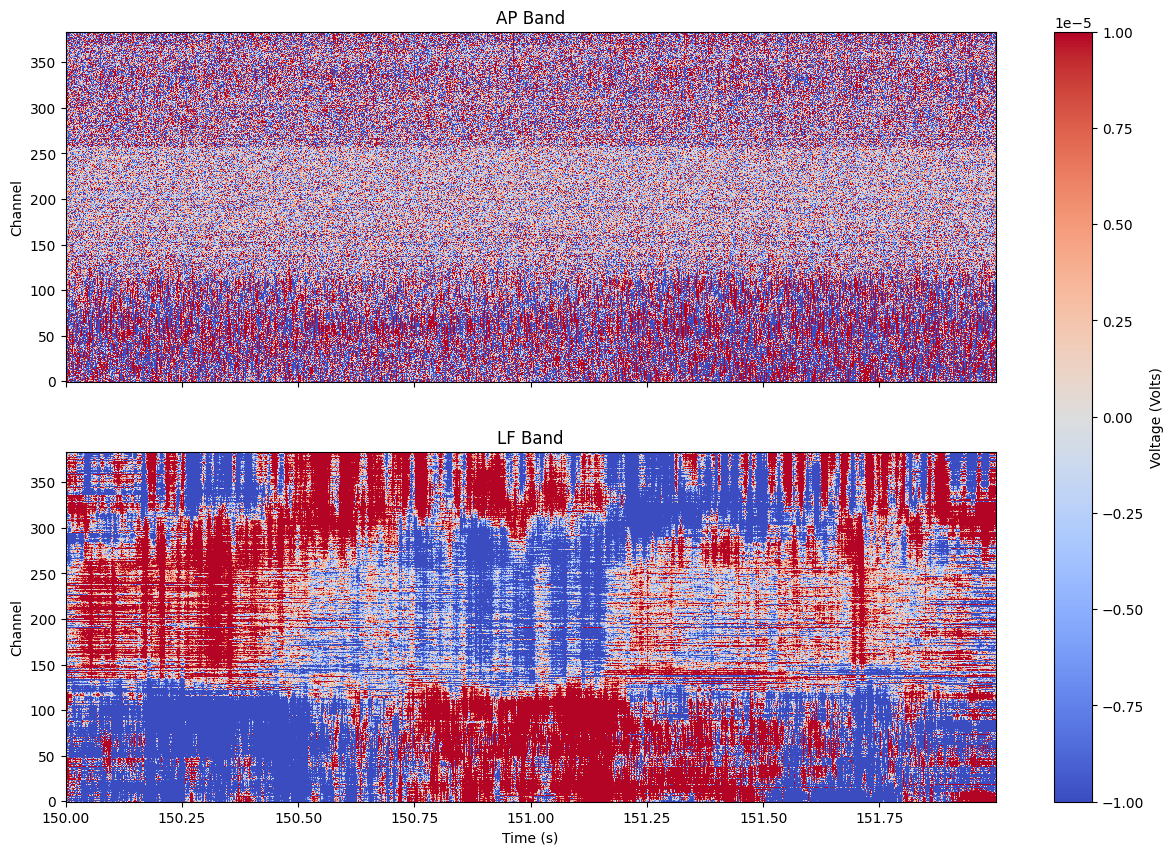

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

pcm1 = axs[0].pcolormesh(
    np.arange(
        start_time, end_time, ((end_time - start_time) / ap_timeframe_data.shape[1])
    ),
    np.arange(0, (ap_timeframe_data.shape[0])),
    ap_timeframe_data,
    shading="auto",
    cmap="coolwarm",
    vmin=-0.00001,
    vmax=0.00001,
)
axs[0].set_title("AP Band")
axs[0].set_ylabel("Channel")

pcm2 = axs[1].pcolormesh(
    np.arange(
        start_time, end_time, ((end_time - start_time) / lf_timeframe_data.shape[1])
    ),
    np.arange(0, (lf_timeframe_data.shape[0])),
    lf_timeframe_data,
    shading="auto",
    cmap="coolwarm",
    vmin=-0.00001,
    vmax=0.00001,
)
axs[1].set_title("LF Band")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Channel")

fig.colorbar(pcm1, ax=axs, orientation="vertical", label="Voltage (Volts)")

### Brief Discussion

The AP band provided by the Neuropixels device represents short-wavelength signals putatively resulting from action potentials. The LF band represents long-wavelength signals putatively resulting from all activity in the local environment, including the influence of the many cells far enough from the probe that their action potentials cannot be identified. These signals alone can be input directly into machine learning algorithms to make predictions about associations with expressed or desired behavior [[11](https://doi.org/10.2196/16194)]. However, this site-specific data does not differentiate the activity of individual cells.

The problem of differentiating the activity of individual cells from this data is relatively new. Neuropixels and related devices have only been developed during the last decade, and have increased bandwidth of data collection by combining volume coverage with spatial and temporal resolution [[9](https://doi.org/10.1038/nature24636), [10](https://doi.org/10.1126/science.abf4588), [11](https://doi.org/10.2196/16194)]. These hardware developments have led to a need for data pipelines that identify individual spikes and assign them to groups associated with putative neurons. I noted in the introduction that these algorithms for spike sorting included more detail than I can feasibly replicate during my master's project, but a leading algorithm, KiloSort, has already been implemented on the IBL data. KiloSort divides the matrix of voltages and channels into sub-matrices with single spikes that could correspond to an action potential, splits spikes that likely correspond to an overlap of multiple action potentials, and assigns each spike to cluster associated with a putative neuron [[12](https://doi.org/10.1038/s41592-024-02232-7), [13](https://proceedings.neurips.cc/paper_files/paper/2016/file/1145a30ff80745b56fb0cecf65305017-Paper.pdf), [14](https://doi.org/10.6084/m9.figshare.19705522.v4)].

As KiloSort has already been implemented [[14](https://doi.org/10.6084/m9.figshare.19705522.v4)] on this data, the next section will demonstrate how to access and use the spike-sorted data.

## Load and Visualize Spike-Sorted Data

### Spike Loader

As with the raw data streamer, IBL provides a class to access spike data.

In [11]:
spike_loader = SpikeSortingLoader(pid=pid, one=one_alyx)

### Load Spike Data

Spike data for an insertion is held by the IBL in three tables: spikes, clusters, and channels.

IBL uses custom data types that are flexible subclasses of dicts to hold the data tables: `Bunch` and `AlfBunch`.

In [12]:
spike_sorting_data: tuple[AlfBunch, AlfBunch, Bunch] = spike_loader.load_spike_sorting()  # type: ignore
spikes, clusters, channels = spike_sorting_data

### Spikes

The spikes table holds a list of all spikes identified and their associated time, voltage, and cluster.

In [13]:
spikes_df = spikes.to_df()
spikes_df

,amps,clusters,depths,times
0,0.000058,512,3413.953125,0.000685
1,0.000077,248,522.224609,0.000818
2,0.000078,89,194.612640,0.000985
3,0.000046,314,877.903320,0.001552
4,0.000067,556,755.919312,0.001552
...,...,...,...,...
27478045,0.000072,287,718.712646,4387.386601
27478046,0.000089,320,859.444580,4387.387934
27478047,0.000050,441,2887.549316,4387.388301
27478048,0.000074,287,714.392090,4387.388468


### Clusters

The clusters table holds a list of clusters identified and associated metadata including a unique identifier, average voltage assigned to the cluster, and recording channels associated with the cluster.

The clusters `AlfBunch` includes a dataframe nested in one of its columns, so we do some wrangling to make a flat 2D data table. The source code of `.to_df()` appears to attempt this, but has a bug, so below is a simplified, more specific, implementation of the flattening.

In [14]:
clusters_wrangled: dict = {}
for k, v in clusters.items():
    if v.ndim == 1:
        clusters_wrangled[k] = v
    elif v.ndim == 2:
        for k_sub in v:
            v_sub = v[k_sub]
            clusters_wrangled[k_sub] = v_sub
    else:
        raise ValueError("Bad dimensions")


clusters_df: pd.DataFrame = pd.DataFrame(clusters_wrangled)
clusters_df

,channels,depths,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,drift,...,spike_count,slidingRP_viol_forced,max_confidence,min_contamination,n_spikes_below2,firing_rate,label,bitwise_fail,ks2_label,uuids
0,0,20.0,0,0.000239,0.000066,0.000128,1.202803,0.000614,0.000606,2.410610e+06,...,208337.0,0.0,1.000000e+02,0.5,38,47.485427,1.000000,0,good,2640eb9c-69b4-40db-ab8b-95ad386007da
1,0,20.0,1,0.000101,0.000045,0.000052,1.373974,0.000000,0.000000,9.437402e+03,...,333.0,0.0,2.291341e+00,NaN,0,0.075899,0.333333,3,mua,6245d874-f12d-44a7-9e61-842b648fae9e
2,1,20.0,2,0.000230,0.000059,0.000080,1.968509,0.426780,0.305181,1.334003e+06,...,69774.0,0.0,7.156311e-06,17.0,1969,15.903311,0.333333,3,mua,060ea9a4-5d33-486f-b53d-1562ced5304c
3,1,20.0,3,0.000168,0.000043,0.000051,1.583340,0.762317,0.481094,8.565348e+05,...,36072.0,0.0,7.356894e-05,22.0,1194,8.221748,0.333333,3,mua,4980e5ab-1a1c-428c-b31a-76c901510593
4,1,20.0,4,0.000088,0.000037,0.000042,1.177437,2.055150,0.972173,1.356305e+05,...,6707.0,0.0,6.957768e-11,NaN,87,1.528700,0.000000,7,mua,26df70b8-00ac-4b77-bf99-63d280eb49e5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,349,3500.0,601,0.000052,0.000044,0.000047,0.454855,0.000000,0.000000,8.965200e+02,...,45.0,0.0,0.000000e+00,NaN,0,0.010257,0.333333,5,mua,348e2d5b-4a53-4b28-943b-85de4115dd03
602,349,3500.0,602,0.000043,0.000032,0.000034,0.613128,0.000000,0.000000,7.628500e+02,...,41.0,0.0,1.998001e-01,NaN,0,0.009345,0.333333,5,mua,ffba0605-08ad-40ce-8dfa-ee80deb8f10e
603,350,3520.0,603,0.000116,0.000051,0.000057,1.019759,0.191065,0.160280,1.833755e+05,...,13735.0,0.0,7.811478e+01,12.0,52,3.130564,0.333333,3,mua,2ede8599-325e-491a-97a0-cbf9421a0ea4
604,294,2960.0,604,0.000080,0.000033,0.000047,1.123559,0.000000,0.000000,8.747828e+03,...,860.0,0.0,5.542513e+01,28.5,0,0.196016,0.333333,5,good,790370fe-a46b-4e46-a13c-fe84ca8fb66b


### Channels

The channels table holds the list of recording channels, and associated anatomical information associated with the Allen Mouse Brain Atlas.

In [15]:
channels_df = AlfBunch(channels).to_df()
channels_df

,x,y,z,acronym,atlas_id,axial_um,lateral_um,labels,rawInd
0,-0.001907,-0.001250,-0.004395,VPL,718,20.0,43.0,0,0
1,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
2,-0.001911,-0.001250,-0.004375,VPL,718,40.0,59.0,0,2
3,-0.001911,-0.001250,-0.004375,VPL,718,40.0,27.0,0,3
4,-0.001915,-0.001248,-0.004356,VPL,718,60.0,43.0,0,4
...,...,...,...,...,...,...,...,...,...
379,-0.003074,-0.000558,-0.000952,SSp-bfd2/3,201,3800.0,27.0,0,379
380,-0.003081,-0.000556,-0.000934,SSp-bfd2/3,201,3820.0,43.0,0,380
381,-0.003081,-0.000556,-0.000934,SSp-bfd2/3,201,3820.0,11.0,0,381
382,-0.003087,-0.000555,-0.000915,SSp-bfd2/3,201,3840.0,59.0,0,382


### Merged Clusters

Data can be joined between tables; for example, the `.merge_clusters` method merges data from spikes and channels to add attributes such as spike voltage statistics and anatomical location to the clusters table.

In [16]:
merged_clusters: AlfBunch = spike_loader.merge_clusters(spikes, clusters, channels)  # type: ignore

In [17]:
merged_clusters_df = merged_clusters.to_df()
merged_clusters_df

,channels,depths,uuids,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,...,ks2_label,x,y,z,acronym,atlas_id,axial_um,lateral_um,labels,rawInd
0,0,20.0,2640eb9c-69b4-40db-ab8b-95ad386007da,0,0.000239,0.000066,0.000128,1.202803,0.000614,0.000606,...,good,-0.001907,-0.001250,-0.004395,VPL,718,20.0,43.0,0,0
1,0,20.0,6245d874-f12d-44a7-9e61-842b648fae9e,1,0.000101,0.000045,0.000052,1.373974,0.000000,0.000000,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,43.0,0,0
2,1,20.0,060ea9a4-5d33-486f-b53d-1562ced5304c,2,0.000230,0.000059,0.000080,1.968509,0.426780,0.305181,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
3,1,20.0,4980e5ab-1a1c-428c-b31a-76c901510593,3,0.000168,0.000043,0.000051,1.583340,0.762317,0.481094,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
4,1,20.0,26df70b8-00ac-4b77-bf99-63d280eb49e5,4,0.000088,0.000037,0.000042,1.177437,2.055150,0.972173,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,349,3500.0,348e2d5b-4a53-4b28-943b-85de4115dd03,601,0.000052,0.000044,0.000047,0.454855,0.000000,0.000000,...,mua,-0.002976,-0.000579,-0.001235,SSp-bfd4,1047,3500.0,11.0,0,349
602,349,3500.0,ffba0605-08ad-40ce-8dfa-ee80deb8f10e,602,0.000043,0.000032,0.000034,0.613128,0.000000,0.000000,...,mua,-0.002976,-0.000579,-0.001235,SSp-bfd4,1047,3500.0,11.0,0,349
603,350,3520.0,2ede8599-325e-491a-97a0-cbf9421a0ea4,603,0.000116,0.000051,0.000057,1.019759,0.191065,0.160280,...,mua,-0.002983,-0.000578,-0.001216,SSp-bfd4,1047,3520.0,59.0,0,350
604,294,2960.0,790370fe-a46b-4e46-a13c-fe84ca8fb66b,604,0.000080,0.000033,0.000047,1.123559,0.000000,0.000000,...,good,-0.002809,-0.000692,-0.001730,SSp-bfd6a,1038,2960.0,59.0,0,294


### Wrangle to Clusters-by-Time Matrix

Our data tables of spikes and clusters have the source data for further analysis, but how can we make use of this?

My initial intuition was to rearrange the spikes table into a clusters-by-time matrix, with binary values to determine firing and rest. The following demonstrates that. For efficiency, we'll keep our timeframe constrained to the same timeframe used with the raw data.

First, trim the timeframe

In [18]:
spikes_df_timeframe = spikes_df[start_time <= spikes_df["times"]]
spikes_df_timeframe = spikes_df_timeframe[spikes_df_timeframe["times"] <= end_time]
spikes_df_timeframe

,amps,clusters,depths,times
1064505,0.000179,213,500.639526,150.000098
1064506,0.000068,287,792.859009,150.000198
1064507,0.000071,76,193.428528,150.000298
1064508,0.000028,374,1119.744629,150.000465
1064509,0.000173,190,459.618500,150.000598
...,...,...,...,...
1080372,0.000131,218,524.351562,151.999812
1080373,0.000071,180,407.717468,151.999812
1080374,0.000066,355,1000.125610,151.999846
1080375,0.000325,129,294.618591,151.999946


Create a new ID for clusters that is ordered by position along the probe, etc.

In [19]:
cluster_channel_map = (
    merged_clusters_df[["cluster_id", "channels"]]
    .copy()
    .sort_values(by="channels", ascending=True)
    .reset_index(drop=True)
    .reset_index(drop=False)
    .rename(inplace=False, columns={"index": "cluster_channel_id"})
)
cluster_channel_map

,cluster_channel_id,cluster_id,channels
0,0,0,0
1,1,1,0
2,2,2,1
3,3,3,1
4,4,4,1
...,...,...,...
601,601,538,367
602,602,590,367
603,603,592,367
604,604,539,371


Join new ID and channel assignment to spikes

In [20]:
us_per_s = 1000000
spikes_df_timeframe = spikes_df_timeframe.merge(
    cluster_channel_map, left_on="clusters", right_on="cluster_id", how="left"
)
spikes_df_timeframe["time_bin_us"] = (
    ((spikes_df_timeframe["times"] - start_time) * us_per_s).round().astype(int)
)  # bin by microsecond
spikes_df_timeframe

,amps,clusters,depths,times,cluster_channel_id,cluster_id,channels,time_bin_us
0,0.000179,213,500.639526,150.000098,219,213,48,98
1,0.000068,287,792.859009,150.000198,300,287,73,198
2,0.000071,76,193.428528,150.000298,73,76,14,298
3,0.000028,374,1119.744629,150.000465,396,374,106,465
4,0.000173,190,459.618500,150.000598,195,190,42,598
...,...,...,...,...,...,...,...,...
15867,0.000131,218,524.351562,151.999812,225,218,49,1999812
15868,0.000071,180,407.717468,151.999812,187,180,41,1999812
15869,0.000066,355,1000.125610,151.999846,376,355,98,1999846
15870,0.000325,129,294.618591,151.999946,130,129,29,1999946


Use spikes_df_timeframe to set spike values in clusters_spikes_matrix

In [21]:
clusters_spikes_matrix = np.zeros(
    (cluster_channel_map.shape[0], ((end_time - start_time) * us_per_s))
)  # type: ignore
clusters_spikes_matrix[
    (
        spikes_df_timeframe["cluster_channel_id"].max()
        - spikes_df_timeframe["cluster_channel_id"].values
    ),
    spikes_df_timeframe["time_bin_us"].values,
] = int(1)  # 1 represents a spike # type: ignore
clusters_spikes_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(606, 2000000))

### Is a Binary Clusters-by-Time Matrix Ideal?

This `clusters_spikes_matrix` matrix has many zero values, which increases the space complexity significantly. Any computation with this matrix will also have a similarly enormous time complexity. At our scale of two seconds in one sample it might be feasible to organize the data in this perhaps more-intuitive way, but this complexity may be a likely reason why the IBL decided to use their more-efficient multi-table structure.

In [22]:
csm_rows = clusters_spikes_matrix.shape[0]
csm_cols = clusters_spikes_matrix.shape[1]
csm_vals = csm_rows * csm_cols
csm_spikes = clusters_spikes_matrix.sum()
csm_spike_ratio = csm_spikes / csm_vals
csm_spike_percent = round((csm_spike_ratio * 100), 4)

print(
    f"There are {csm_vals} values in `clusters_spikes_matrix`, but only {csm_spikes} ({csm_spike_percent}%) correspond to a spike."
)

There are 1212000000 values in `clusters_spikes_matrix`, but only 15872.0 (0.0013%) correspond to a spike.


### Visualize Spikes by Cluster with a Clusters-by-Time Matrix

Let's try using our clusters-by-time matrix for time-series visualization.

Text(0, 0.5, 'Putative Neuron')

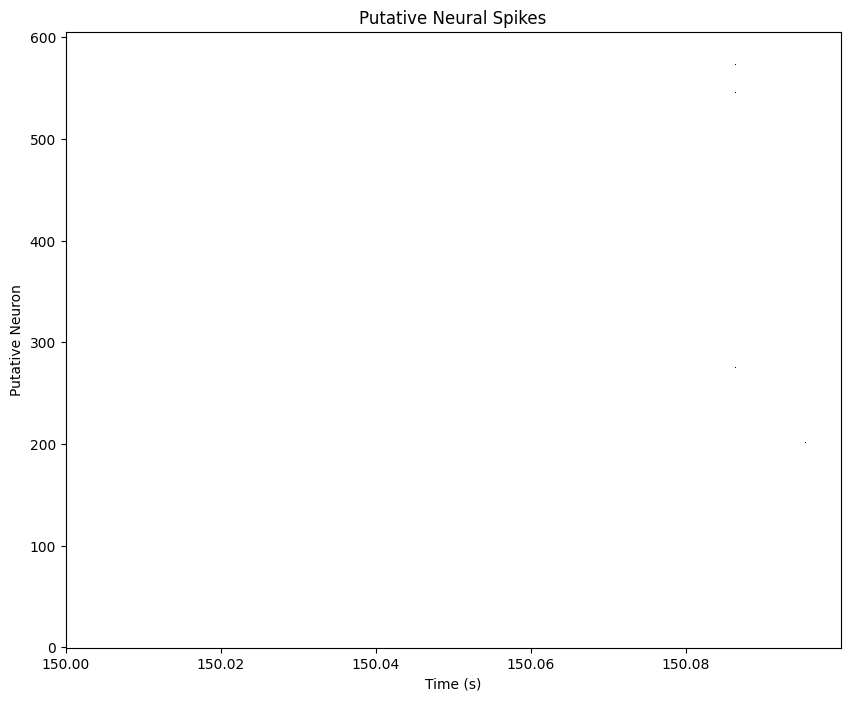

In [23]:
fig, axs = plt.subplots(figsize=(10, 8))

pcm3 = plt.pcolormesh(
    np.arange(
        start_time,
        end_time,
        ((end_time - start_time) / clusters_spikes_matrix.shape[1]),
    )[0:100000],
    np.arange(0, (clusters_spikes_matrix.shape[0])),
    clusters_spikes_matrix[:, 0:100000],
    shading="auto",
    cmap="Grays",
    vmin=0.0,
    vmax=1,
)
axs.set_title("Putative Neural Spikes")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Putative Neuron")

This plot only includes 0.1 seconds of recording time, and took almost 30 seconds to generate on my computer. It also doesn't show many spikes. An example of a spike is near cluster 575 at 150.06 seconds.

This clearly shows that my initial intuition to use a clusters-by-time matrix is not an ideal way to store, visualize, or understand the spikes. I'll use the more efficient spikes data table moving forward.

### A More Efficient Visualization

In [`Wrangle to Clusters-by-Time Matrix`](#wrangle-to-clusters-by-time-matrix), we created a list of spikes, `spikes_df_timeframe`, including `times` and `cluster_channel_id`. I'll use that for visualization.

Text(0, 0.5, 'Putative Neuron')

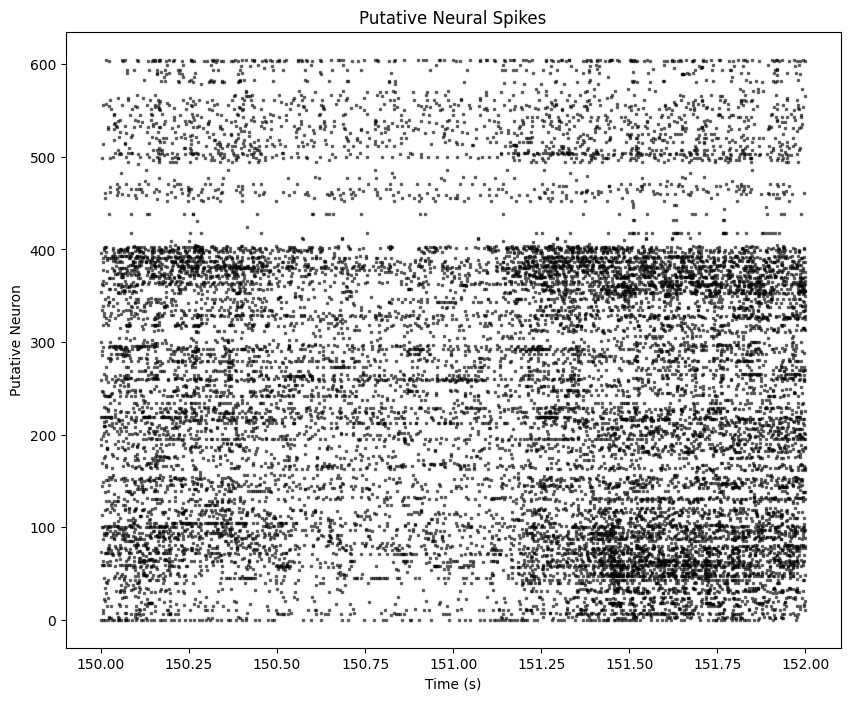

In [24]:
fig, axs = plt.subplots(figsize=(10, 8))

axs.scatter(
    spikes_df_timeframe["times"].values,  # type: ignore
    spikes_df_timeframe["cluster_channel_id"].values,  # type: ignore
    s=1,
    alpha=0.5,
    c="#000000",
    marker="s",
)

axs.set_title("Putative Neural Spikes")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Putative Neuron")

Here is a visualization of only seconds 150-150.1, which aligns with the plot in [`Visualize Spikes by Cluster with a Clusters-by-Time Matrix`](#visualize-spikes-by-cluster-with-a-clusters-by-time-matrix). This plot, however, shows more activity because values of zero are not assigned a color by matplotlib the way they are in that heatmap visualization.

Text(0, 0.5, 'Putative Neuron')

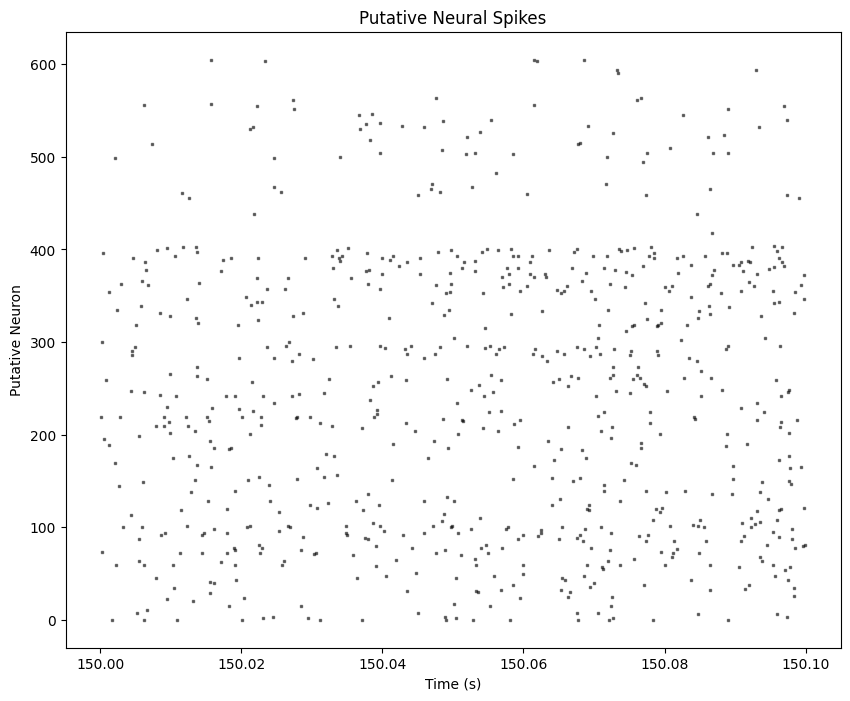

In [25]:
fig, axs = plt.subplots(figsize=(10, 8))

axs.scatter(
    spikes_df_timeframe[spikes_df_timeframe["times"] <= 150.1]["times"].values,  # type: ignore
    spikes_df_timeframe[spikes_df_timeframe["times"] <= 150.1][
        "cluster_channel_id"
    ].values,  # type: ignore
    s=1,
    alpha=0.5,
    c="#000000",
    marker="s",
)

axs.set_title("Putative Neural Spikes")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Putative Neuron")

## Conclusion

Here we have demonstrated access to the IBL dataset, including an explanation of data retrieved that will be relevant to future algorithms in this project. Later deliverables in the project will make use of these data, applying algorithms for to identify neural connections.